## Import Packages and Authenticate

In [35]:
# Dependencies
import tweepy
import pandas as pd
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import time
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
from config import (consumer_key, consumer_secret,
                    access_token, access_token_secret)

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

## Pull Mentions

In [10]:
# Search for all tweets with "@JohnZalk Analyze:"
search_term = "@JohnZalk Analyze:"

# List of mentions
mention_list = []

mentions = api.search(search_term, count=100)

for mention in mentions["statuses"]:
    
    # add tweets to the list
    mention_list.append({'Account' : mention["text"].split(": ",1)[1],
                         # convert date
                         'Date' : time.strftime('%Y-%m-%d %H:%M:%S',
                                                time.strptime(mention['created_at'],
                                                              '%a %b %d %H:%M:%S +0000 %Y'))})

# turn tweets to df
mention_list
mention_df = pd.DataFrame(mention_list)
mention_df.head()

,Account,Date
0,@espn,2019-11-07 15:55:35
1,@DennisRodman,2019-11-07 15:46:30
2,@DwyaneWade,2019-11-07 15:19:24
3,@BarackObama,2019-11-07 15:18:04
4,@espn,2019-11-06 13:49:34


In [14]:
#remove Account that have been mentioned twice
counts = mention_df['Account'].value_counts()
counts

counts = counts.to_dict() #converts to dictionary

#add counts to mentions df
mention_df['Count'] = mention_df['Account'].map(counts) 

#remove counts > 1
mention_df = mention_df[mention_df.Count < 2]
mention_df

,Account,Date,Count
1,@DennisRodman,2019-11-07 15:46:30,1
2,@DwyaneWade,2019-11-07 15:19:24,1
3,@BarackObama,2019-11-07 15:18:04,1


In [15]:
#take most recent mention
recent_date = mention_df['Date'].max()
mention_df=mention_df[mention_df['Date'] == recent_date]
mention_df
#turn account value to string
target_account = mention_df.iloc[0]['Account']
target_account

'@DennisRodman'

## Pull Last 500 Tweets and Store in DF

In [16]:
tweet_list =[]

# Loop through 21 pages of tweets (total 500 tweets)
for x in range(1, 21):

    # Get all tweets from home feed
    tweets = api.user_timeline(target_account, page=x)

    # Loop through all tweets and print the tweet text
    for tweet in tweets:
        tweet_list.append(tweet['text'])
        
tweet_list
tweet_df = pd.DataFrame(tweet_list)
tweet_df.head()

,0
0,Got artist @patrick_ganino to paint this portr...
1,Get your limited edition basketball with artwo...
2,Limited edition basketball with reproduction o...
3,@KuzPalms @NBA Thanks dude.
4,@stinkylewis2k @Ballislife @NBA Replied.


In [29]:
#rename column
tweet_df.rename(columns = {0:'Tweet'}, inplace = True)
##create column Tweets Ago for x axis of sentiment plot
# count nuber of tweets becuase not all accounts have 500 and make number negative
number_tweets = -len(tweet_df)
#create an array 0 through number_tweets
tweets_ago = np.arange(0,number_tweets,-1)
#add array as column in df
tweet_df['Tweets Ago'] = tweets_ago
# create polarity column that's 0 for now
tweet_df['Tweet Polarity'] = 0
tweet_df.head()

,Tweet,Tweets Ago,Tweet Polarity
0,Got artist @patrick_ganino to paint this portr...,0,0
1,Get your limited edition basketball with artwo...,-1,0
2,Limited edition basketball with reproduction o...,-2,0
3,@KuzPalms @NBA Thanks dude.,-3,0
4,@stinkylewis2k @Ballislife @NBA Replied.,-4,0


## Compute Polarity Score

In [33]:
# loop through tweets and compute polarity score. Append score to list.
polarity=[]
for row in tweet_df['Tweet']:
    results = analyzer.polarity_scores(row)
    polarity.append(results['compound'])

# turn list into df column
tweet_df['Tweet Polarity'] = polarity
tweet_df.head()

,Tweet,Tweets Ago,Tweet Polarity
0,Got artist @patrick_ganino to paint this portr...,0,0.7845
1,Get your limited edition basketball with artwo...,-1,-0.4215
2,Limited edition basketball with reproduction o...,-2,-0.2263
3,@KuzPalms @NBA Thanks dude.,-3,0.4404
4,@stinkylewis2k @Ballislife @NBA Replied.,-4,0.0000


## Plot

(-1, 1)

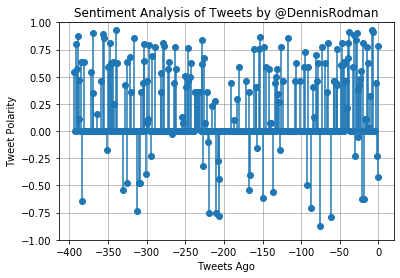

In [49]:
plt.stem(tweet_df['Tweets Ago'], tweet_df['Tweet Polarity'], basefmt=' ', use_line_collection = True)
plt.title("Sentiment Analysis of Tweets by " + target_account)
plt.ylabel('Tweet Polarity')
plt.xlabel("Tweets Ago")
plt.grid(linestyle='-', linewidth='0.5', color='grey')
plt.ylim(-1,1)

## Tweet Plot